# Optimal assignment problem

### 1. Generate two point clouds

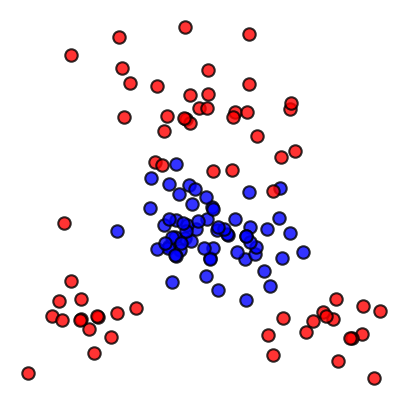

In [1]:
import numpy as np
from utils import cloud_plot

n = 64  # Number of points in first point cloud
m = n  # Number of points in second point cloud

# Generate point clouds a and b
def generate_point_clouds(n, m):
    """
    This function is modified from the following notebook:
    https://nbviewer.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_1_linprog.ipynb
    """
    gauss = lambda q, a, c: a * np.random.randn(2, q) + np.transpose(np.tile(c, (q, 1)))
    a = (np.random.randn(2, n)*.3).transpose()
    b = (np.hstack((gauss(int(m/2), .5, [0, 1.6]),
         np.hstack((gauss(int(m/4), .3, [-1, -1]), 
                    gauss(int(m/4), .3, [1, -1])))))).transpose()
    
    return a, b

a, b = generate_point_clouds(n, m)

cloud_plot(a, b)

### 2. Define the cost/benefit matrix

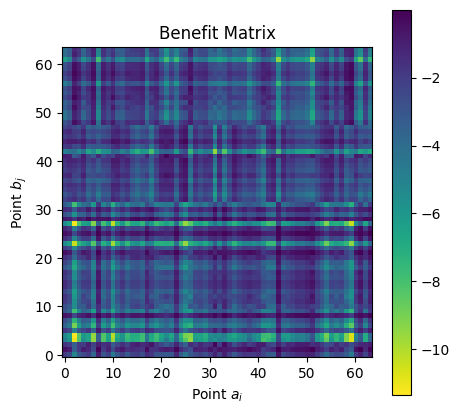

In [2]:
from optimal_transport import cost_matrix
import matplotlib.pyplot as plt

p = 2
c_matrix = cost_matrix(a, b, p)

plt.figure(figsize=(5, 5))
plt.imshow(-c_matrix.transpose(), cmap='viridis_r')
plt.gca().invert_yaxis()
plt.title('Benefit Matrix')
plt.xlabel('Point $a_{i}$')
plt.ylabel('Point $b_{j}$')
plt.colorbar()
plt.show()

### 3. Solve for the optimal assignments

#### Auction algorithm

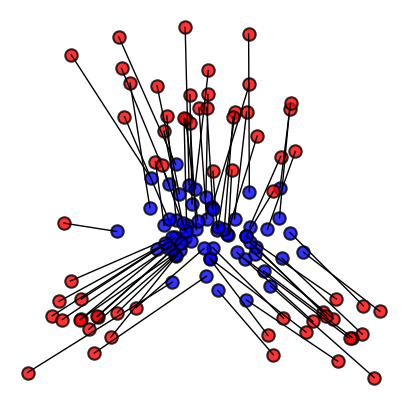

In [4]:
from optimal_transport import auction_algorithm

e_start = 1e2
e_end = 1e-5
e_fac = 8
assignments = auction_algorithm(a[None], b[None], p, e_start, e_end, e_fac)

cloud_plot(a, b, assignments.squeeze())

#### Convex optimisation

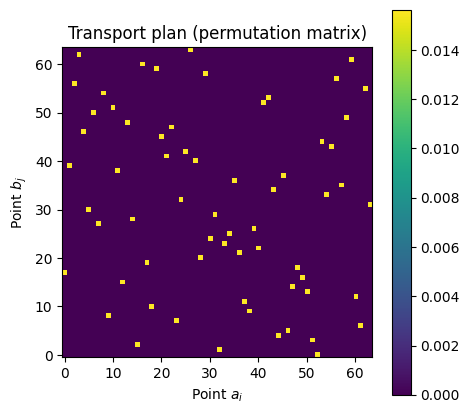

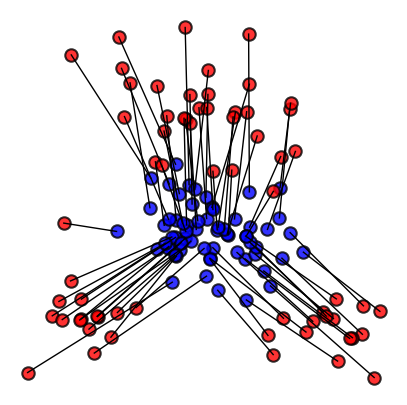

In [5]:
import cvxpy as cp

x = np.ones([n, 1])/n
y = x

t = cp.Variable((n, m))

# Define the set of discrete couplings between alpha and beta measures
u = np.ones((m, 1))
v = np.ones((n, 1))

# Define optimization constraints
constraints = [0 <= t, cp.matmul(t, u)==x, cp.matmul(t.T, v)==y]

# Define and solve the Kantorovich problem
objective = cp.Minimize(cp.sum(cp.multiply(t, c_matrix.T)))
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.ECOS)

plt.figure(figsize=(5, 5))
plt.imshow(t.value, cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Transport plan (permutation matrix)')
plt.xlabel('Point $a_{i}$')
plt.ylabel('Point $b_{j}$')
plt.colorbar()
plt.show()

cloud_plot(a, b, t_plan=t.T)

### 4. Validate optimal assignments

In [6]:
i_ind, j_ind = np.nonzero(t.value > 1e-5)

assert np.sum(assignments != j_ind) == 0

### 5. Computational performance

In [7]:
n = 512
m = n

a, b = generate_point_clouds(n, m)

In [8]:
c_matrix = cost_matrix(a, b, p)
x = np.ones([n, 1])/n
y = x

t = cp.Variable((n, m))
u = np.ones((m, 1))
v = np.ones((n, 1))

constraints = [0 <= t, cp.matmul(t, u)==x, cp.matmul(t.T, v)==y]
objective = cp.Minimize(cp.sum(cp.multiply(t, c_matrix.T)))
prob = cp.Problem(objective, constraints)

In [9]:
%%timeit

result = prob.solve(solver=cp.ECOS)

6.8 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
from scipy.optimize import linear_sum_assignment

In [11]:
%%timeit

c_matrix = cost_matrix(a, b)
i_ind, j_ind = linear_sum_assignment(c_matrix.T)

111 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit

assignments = auction_algorithm(a[None], b[None], p, e_start, e_end, e_fac)

82.9 ms ± 845 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
